Foldername : 0 - 20
Filename : 정유경1.wav
Filename : 정유경10.wav
Filename : 정유경11.wav
Filename : 정유경12.wav
Filename : 정유경13.wav
Filename : 정유경14.wav
Filename : 정유경15.wav
Filename : 정유경16.wav
Filename : 정유경17.wav
Filename : 정유경18.wav
Filename : 정유경19.wav
Filename : 정유경2.wav
Filename : 정유경20.wav
Filename : 정유경3.wav
Filename : 정유경4.wav
Filename : 정유경5.wav
Filename : 정유경6.wav
Filename : 정유경7.wav
Filename : 정유경8.wav
Filename : 정유경9.wav
Foldername : 1 - 20
Filename : baecheolsu1.wav
Filename : baecheolsu10.wav
Filename : baecheolsu11.wav
Filename : baecheolsu12.wav
Filename : baecheolsu13.wav
Filename : baecheolsu14.wav
Filename : baecheolsu2.wav
Filename : baecheolsu3.wav
Filename : baecheolsu4.wav
Filename : baecheolsu5.wav
Filename : baecheolsu6.wav
Filename : baecheolsu7.wav
Filename : baecheolsu8.wav
Filename : baecheolsu9.wav
Filename : 배철수15.wav
Filename : 배철수16.wav
Filename : 배철수17.wav
Filename : 배철수18.wav
Filename : 배철수19.wav
Filename : 배철수20.wav
Foldername : 2 - 20
Filename : 새로운 녹음 26

C:\Users\ImChanjoo\anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


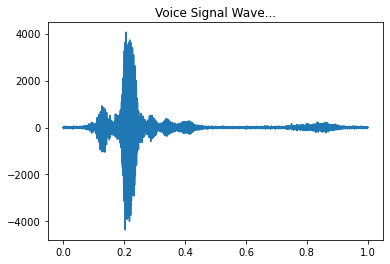

train_data.shape : (53381, 13) <class 'numpy.ndarray'>
train_label.shape : (53381,) <class 'numpy.ndarray'>


C:\Users\ImChanjoo\anaconda3\envs\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ImChanjoo\anaconda3\envs\python37\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[1 1 0 2 0 0 2 2 2 2 2 4 1 0 1 2 2 2 0 2 1 2 0 0 0 0 2 0 0 1 2 1 1 0 2 1 1
 1 1 1 1 0 1 0 0 1 4 0 2 1 2 2 1 1 1 3 1 2 0 0 0 0 0 0 2 0 0 2 1 0 2 2 2 1
 2 1 1 2 4 2 0 4 1 2 2 1 0 2 0 1 1 1 1 0 0 3 3 1 0 0 2 2 0 2 2 0 0 0 0 0 0
 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 2
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 3 3 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 2 0 0 0 3 3
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 3 3 1 1 3 1 1 0 0 2 0 4 2 0 0 0 0 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

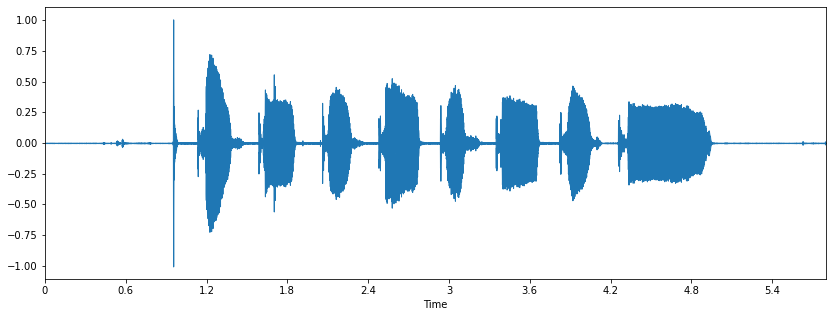

In [4]:
##### 화자인식 일반 머신러닝 코드 #####
import librosa
import librosa.display
import pyaudio #마이크를 사용하기 위한 라이브러리
import wave
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.linear_model import LogisticRegression#텐서플로우로 바꿀예정
import os
##### 변수 설정 부분 #####
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100 #비트레이트 설정
CHUNK = int(RATE / 10) # 버퍼 사이즈 1초당 44100비트레이트 이므로 100ms단위
RECORD_SECONDS = 1 #녹음할 시간 설정
WAVE_OUTPUT_FILENAME = "output.wav"
DATA_PATH = "./data/"
train_data=[]#train_date 저장할 공강
train_label=[]#train_label 저장할 
test_data=[]#train_date 저장할 공강
test_label=[]#train_label 저장할 
##########################

def load_wave_generator(path): 
       
    batch_waves = []
    labels = []
    # input_width=CHUNK*6 # wow, big!!
    folders = os.listdir(path)
    #while True:
       # print("loaded batch of %d files" % len(files))
    for folder in folders:
        if not os.path.isdir(path):continue #폴더가 아니면 continue                   
        files = os.listdir(path+"/"+folder)        
        print("Foldername :",folder,"-",len(files))#폴더 이름과 그 폴더에 속하는 파일 갯수 출력
        for wav in files:
            if not wav.endswith(".wav"):continue
            else:
                global train_data,train_label#전역변수를 사용하겠다.
                print("Filename :",wav)#.wav 파일이 아니면 continue
                y, sr = librosa.load(path+"/"+folder+"/"+wav)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=int(sr*0.01),n_fft=int(sr*0.02)).T
                if(len(train_data)==0):
                    train_data = mfcc
                    train_label = np.full(len(mfcc), int(folder))
                else:
                    train_data = np.concatenate((train_data, mfcc), axis = 0)
                    train_label = np.concatenate((train_label, np.full(len(mfcc),  int(folder))), axis = 0)
                    #print("mfcc :",mfcc.shape)
                
load_wave_generator(DATA_PATH)


######## 음성 데이터를 녹음 해 저장하는 부분 ########

p = pyaudio.PyAudio() # 오디오 객체 생성

stream = p.open(format=FORMAT, # 16비트 포맷
                channels=CHANNELS, #  모노로 마이크 열기
                rate=RATE, #비트레이트
                input=True,
                frames_per_buffer=CHUNK) # CHUNK만큼 버퍼가 쌓인다.

print("Start to record the audio.")

frames = [] # 음성 데이터를 채우는 공간

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)): 
    #지정한  100ms를 몇번 호출할 것인지 10 * 5 = 50  100ms 버퍼 50번채움 = 5초
    data = stream.read(CHUNK)
    frames.append(data)

print("Recording is finished.")

stream.stop_stream() # 스트림닫기
stream.close() # 스트림 종료
p.terminate() # 오디오객체 종료

# WAVE_OUTPUT_FILENAME의 파일을 열고 데이터를 쓴다.
wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb') 
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

spf = wave.open(WAVE_OUTPUT_FILENAME,'r')

signal = spf.readframes(-1)
signal = np.fromstring(signal, dtype=np.int16)

#시간 흐름에 따른 그래프를 그리기 위한 부분
Time = np.linspace(0,len(signal)/RATE, num=len(signal)) 

plt.figure(1)
plt.title('Voice Signal Wave...')
#plt.plot(signal) // 음성 데이터의 그래프
plt.plot(Time, signal)
plt.show()


######## 음성 데이터를 읽어와 학습 시키는 부분 ########

print("train_data.shape :", train_data.shape, type(train_data))
print("train_label.shape :", train_label.shape, type(train_label))
#print(mfcc[0])
#print(train_label)
clf = LogisticRegression()
clf.fit(train_data,train_label)

y, sr = librosa.load("./test_정유경.wav")
#y, sr = librosa.load("./baecheolsu15.wav")
plt.figure(figsize=(14,5))
librosa.display.waveplot(y, sr)
#y, sr = librosa.load(WAVE_OUTPUT_FILENAME)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=int(sr*0.01),n_fft=int(sr*0.02)).T

y_test_estimated = clf.predict(mfcc)
print(y_test_estimated)
test_label = np.full(len(mfcc), 0)
print(test_label)
'''
0 유인나
1 배철수
2 이재은
3 최일구
4 문재인 대통령
'''
# 정답률 구하기 
ac_score = metrics.accuracy_score(y_test_estimated, test_label)
print("정답률 =", ac_score)
print(pd.value_counts(pd.Series(y_test_estimated)))


In [3]:
##### 단순히 목소리 녹음을 위한 부분 #####

import pyaudio #마이크를 사용하기 위한 라이브러리
import wave #.wav 파일을 저장하기 위한 라이브러리
import os
######## 음성 데이터를 녹음 해 저장하는 부분 ########
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100 #비트레이트 설정
CHUNK = int(RATE / 10) # 버퍼 사이즈 1초당 44100비트레이트 이므로 100ms단위
RECORD_SECONDS = 5 #녹음할 시간 설정
#WAVE_OUTPUT_FILENAME = "./data/train/1/baecheolsu15.wav"
WAVE_OUTPUT_FILENAME = "./data/4/"
FILE_NAME = "임찬주"

files = os.listdir(WAVE_OUTPUT_FILENAME)
wave_count = 1;
     #폴더 이름과 그 폴더에 속하는 파일 갯수 출력
for wav in files: 
    if not wav.endswith(".wav"):continue
    else: wave_count = wave_count+1


WAVE_OUTPUT_FILENAME = WAVE_OUTPUT_FILENAME+FILE_NAME+str(wave_count)+".wav"
print(str(wave_count)+"개의 .wav존재!",WAVE_OUTPUT_FILENAME)
p = pyaudio.PyAudio() # 오디오 객체 생성

stream = p.open(format=FORMAT, # 16비트 포맷
                channels=CHANNELS, #  모노로 마이크 열기
                rate=RATE, #비트레이트
                input=True,
                frames_per_buffer=CHUNK) # CHUNK만큼 버퍼가 쌓인다.

print("Start to record the audio.")

frames = [] # 음성 데이터를 채우는 공간

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)): 
    #지정한  100ms를 몇번 호출할 것인지 10 * 5 = 50  100ms 버퍼 50번채움 = 5초
    data = stream.read(CHUNK)
    frames.append(data)

print("Recording is finished.")

stream.stop_stream() # 스트림닫기
stream.close() # 스트림 종료
p.terminate() # 오디오객체 종료

wf = wave.open( WAVE_OUTPUT_FILENAME, 'wb') 
# WAVE_OUTPUT_FILENAME의 파일을 열고 데이터를 쓴다.
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

22개의 .wav존재! ./data/4/임찬주22.wav
Start to record the audio.
Recording is finished.


In [4]:
#######################이건 함수 테스트 하는부분
import librosa
import pyaudio #마이크를 사용하기 위한 라이브러리
import wave
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression#텐서플로우로 바꿀예정
import os
##### 변수 설정 부분 #####
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100 #비트레이트 설정
CHUNK = int(RATE / 10) # 버퍼 사이즈 1초당 44100비트레이트 이므로 100ms단위
RECORD_SECONDS = 5 #녹음할 시간 설정
WAVE_OUTPUT_FILENAME = "output.wav"
DATA_PATH = "./data/"
X_train = []#train_data 저장할 공간
X_test = []
Y_train = []
Y_test = []
def load_wave_generator(path): 
       
    batch_waves = []
    labels = []
    X_data = []
    Y_label = []
    idx = 0
    global X_train, X_test, Y_train, Y_test
    folders = os.listdir(path)

    for folder in folders:
        if not os.path.isdir(path):continue #폴더가 아니면 continue                   
        files = os.listdir(path+"/"+folder)        
        print("Foldername :",folder,"-",len(files))
        #폴더 이름과 그 폴더에 속하는 파일 갯수 출력
        for wav in files:
            if not wav.endswith(".wav"):continue
            else:               
                print("Filename :",wav)#.wav 파일이 아니면 continue
                y, sr = librosa.load(path+"/"+folder+"/"+wav)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=int(sr*0.01),n_fft=int(sr*0.02)).T
                X_data.extend(mfcc)
                label = [0 for i in range(len(folders))]
                label[idx] = 1
                for i in range(len(mfcc)):
                    Y_label.append(label)       
        idx = idx+1
    #end loop
    print("X_data :",np.shape(X_data))
    print("Y_label :",np.shape(Y_label))
    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_label)
    
    #3d to 2d
#     nsamples, nx, ny = np.shape(X_train)
#     X_train = np.reshape(X_train,(nsamples,nx*ny))
#     nsamples, nx, ny = np.shape(X_test)
#     X_test = np.reshape(X_test,(nsamples,nx*ny))    
    
#     Y_train = np.argmax(Y_train, axis=1)###one-hot을 합침
#     Y_test = np.argmax(Y_test, axis=1)###one-hot을 합침
    xy = (X_train, X_test, Y_train, Y_test)
    np.save("./data.npy",xy)
    #print(X_data)
    #print(Y_label)
                
load_wave_generator(DATA_PATH)

#t = np.array(X_train);
#print("!!!!!!!!",t,t.shape,X_train)
print("X_train :",np.shape(X_train))
print("X_test :",np.shape(X_test))
print("Y_train :",np.shape(Y_train))
print("Y_test :",np.shape(Y_test))

clf = LogisticRegression()
clf.fit(X_train, np.argmax(Y_train, axis=1))




Foldername : 0 - 20
Filename : 정유경1.wav


C:\Users\ImChanjoo\anaconda3\envs\python37\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Filename : 정유경10.wav
Filename : 정유경11.wav
Filename : 정유경12.wav
Filename : 정유경13.wav
Filename : 정유경14.wav
Filename : 정유경15.wav
Filename : 정유경16.wav
Filename : 정유경17.wav
Filename : 정유경18.wav
Filename : 정유경19.wav
Filename : 정유경2.wav
Filename : 정유경20.wav
Filename : 정유경3.wav
Filename : 정유경4.wav
Filename : 정유경5.wav
Filename : 정유경6.wav
Filename : 정유경7.wav
Filename : 정유경8.wav
Filename : 정유경9.wav
Foldername : 1 - 20
Filename : baecheolsu1.wav
Filename : baecheolsu10.wav
Filename : baecheolsu11.wav
Filename : baecheolsu12.wav
Filename : baecheolsu13.wav
Filename : baecheolsu14.wav
Filename : baecheolsu2.wav
Filename : baecheolsu3.wav
Filename : baecheolsu4.wav
Filename : baecheolsu5.wav
Filename : baecheolsu6.wav
Filename : baecheolsu7.wav
Filename : baecheolsu8.wav
Filename : baecheolsu9.wav
Filename : 배철수15.wav
Filename : 배철수16.wav
Filename : 배철수17.wav
Filename : 배철수18.wav
Filename : 배철수19.wav
Filename : 배철수20.wav
Foldername : 2 - 20
Filename : 새로운 녹음 26.wav
Filename : 새로운 녹음 27.wav
Filename :

C:\Users\ImChanjoo\anaconda3\envs\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [5]:
############### 일반 머신러닝에서 전체적인 정확도 측정 ###########

y_test_estimated = clf.predict(X_test)

# 정답률 구하기 
ac_score = metrics.accuracy_score(np.argmax(Y_test, axis=1), y_test_estimated)
print("정답률 =", ac_score)
print(pd.value_counts(pd.Series(y_test_estimated)))


#y, sr = librosa.load("./youinna16.wav")
#y, sr = librosa.load("./baecheolsu15.wav")
y, sr = librosa.load("./test_정유경.wav")

mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=int(sr*0.01),n_fft=int(sr*0.02)).T
print(mfcc.shape)

y_test_estimated = clf.predict(mfcc)

# 정답률 구하기 
ac_score = metrics.accuracy_score(np.full(len(mfcc),0), y_test_estimated)
print("정답률 =", ac_score)
print(pd.value_counts(pd.Series(y_test_estimated)))


정답률 = 0.6405445180279618
4    3620
0    3109
2    2721
1    2143
3    1997
dtype: int64


C:\Users\ImChanjoo\anaconda3\envs\python37\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(582, 13)
정답률 = 0.7457044673539519
0    434
1     62
4     42
2     24
3     20
dtype: int64


In [15]:
#######################Tensorflow 코드 시작부분
import librosa
import pyaudio #마이크를 사용하기 위한 라이브러리
import wave
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split



import os
##### 변수 설정 부분 #####
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100 #비트레이트 설정
CHUNK = int(RATE / 10) # 버퍼 사이즈 1초당 44100비트레이트 이므로 100ms단위
RECORD_SECONDS = 5 #녹음할 시간 설정
WAVE_OUTPUT_FILENAME = "output.wav"
DATA_PATH = "./data"
X_train = []#train_data 저장할 공간
X_test = []
Y_train = []
Y_test = []
tf_classes = 0
def load_wave_generator(path): 
       
    batch_waves = []
    labels = []
    X_data = []
    Y_label = []    
    global X_train, X_test, Y_train, Y_test, tf_classes
    
    folders = os.listdir(path)

    for folder in folders:
        if not os.path.isdir(path):continue #폴더가 아니면 continue                   
        files = os.listdir(path+"/"+folder)        
        print("Foldername :",folder,"-",len(files),"파일")
        #폴더 이름과 그 폴더에 속하는 파일 갯수 출력
        for wav in files:
            if not wav.endswith(".wav"):continue
            else:               
                #print("Filename :",wav)#.wav 파일이 아니면 continue
                y, sr = librosa.load(path+"/"+folder+"/"+wav)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=int(sr*0.01),n_fft=int(sr*0.02)).T
              
                X_data.extend(mfcc)
               # print(len(mfcc))
                
                label = [0 for i in range(len(folders))]
                label[tf_classes] = 1
                
                for i in range(len(mfcc)):
                    Y_label.append(label)
                #print(Y_label)
        tf_classes = tf_classes+1
    #end loop
    print("X_data :",np.shape(X_data))
    print("Y_label :",np.shape(Y_label))
    X_train, X_test, Y_train, Y_test = train_test_split(np.array(X_data), np.array(Y_label))

    xy = (X_train, X_test, Y_train, Y_test)
    np.save("./data.npy",xy)

load_wave_generator(DATA_PATH)

#t = np.array(X_train);
#print("!!!!!!!!",t,t.shape,X_train)
print(tf_classes,"개의 클래스!!")
print("X_train :",np.shape(X_train))
print("Y_train :",np.shape(Y_train))
print("X_test :",np.shape(X_test))
print("Y_test :",np.shape(Y_test))
####################
#clf = LogisticRegression()
#clf.fit(X_train, Y_train)
####################



Foldername : 0 - 20 파일
Foldername : 1 - 20 파일
Foldername : 2 - 20 파일
Foldername : 3 - 20 파일
Foldername : 4 - 1 파일
X_data : (48372, 13)
Y_label : (48372, 5)
5 개의 클래스!!
X_train : (36279, 13)
Y_train : (36279, 5)
X_test : (12093, 13)
Y_test : (12093, 5)


In [16]:
##################  화자인식 NN 버전 ##################
X_train, X_test, Y_train, Y_test = np.load("./data.npy")
X_train = X_train.astype("float")
X_test = X_test.astype("float")

tf.reset_default_graph() 
tf.set_random_seed(777)
learning_rate = 0.001
training_epochs = 100
keep_prob = tf.placeholder(tf.float32)
sd = 1 / np.sqrt(13) # standard deviation 표준편차(표본표준편차라 1/root(n))

#mfcc의 기본은 20
# 20ms일 때216은 각 mfcc feature의 열이 216
X = tf.placeholder(tf.float32, [None, 13])
# 
Y = tf.placeholder(tf.float32, [None, tf_classes])

# W = tf.Variable(tf.random_normal([216, 200]))
# b = tf.Variable(tf.random_normal([200]))

#1차 히든레이어
W1 = tf.get_variable("w1",
    #tf.random_normal([216, 180], mean=0, stddev=sd),
        shape=[13, 256],
                     initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([256], mean=0, stddev=sd), name="b1")
L1 = tf.nn.relu(tf.matmul(X, W1) + b1) # 1차 히든레이어는 'Relu' 함수를 쓴다.
L1 = tf.nn.dropout(L1, keep_prob = keep_prob)

# 2차 히든 레이어
W2 = tf.get_variable("w2",
    #tf.random_normal([180, 150], mean=0, stddev=sd),
         shape=[256, 256],
                     initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([256], mean=0, stddev=sd), name="b2")
L2 = tf.nn.tanh(tf.matmul(L1, W2) + b2) # 2차 히든레이어는 'Relu' 함수를 쓴다.
L2 = tf.nn.dropout(L2, keep_prob = keep_prob)

# 3차 히든 레이어
W3 = tf.get_variable("w3",
    #tf.random_normal([150, 100], mean=0, stddev=sd),
            shape=[256, 256],
                     initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([256], mean=0, stddev=sd), name="b3")
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3) # 3차 히든레이어는 'Relu' 함수를 쓴다.
L3 = tf.nn.dropout(L3, keep_prob = keep_prob)

# 4차 히든 레이어
W4 = tf.get_variable("w4",
    #tf.random_normal([100, 50], mean=0, stddev=sd),
             shape=[256, 128],
                     initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([128], mean=0, stddev=sd), name="b4")
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4) # 4차 히든레이어는 'Relu' 함수를 쓴다.
L4 = tf.nn.dropout(L4, keep_prob = keep_prob)

# 5차 히든 레이어
W5 = tf.get_variable("w5",
    #tf.random_normal([100, 50], mean=0, stddev=sd),
             shape=[128, 128],
                     initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([128], mean=0, stddev=sd), name="b5")
L5 = tf.nn.relu(tf.matmul(L4, W5) + b5) # 5차 히든레이어는 'Relu' 함수를 쓴다.
L5 = tf.nn.dropout(L5, keep_prob = keep_prob)

# 6차 히든 레이어
W6 = tf.get_variable("w6",
    #tf.random_normal([100, 50], mean=0, stddev=sd),
             shape=[128, 128],
                     initializer=tf.contrib.layers.xavier_initializer())
b6 = tf.Variable(tf.random_normal([128], mean=0, stddev=sd), name="b6")
L6 = tf.nn.relu(tf.matmul(L5, W6) + b6) # 6차 히든레이어는 'Relu' 함수를 쓴다.
L6 = tf.nn.dropout(L6, keep_prob = keep_prob)

# 7차 히든 레이어
W7 = tf.get_variable("w7",
    #tf.random_normal([100, 50], mean=0, stddev=sd),
             shape=[128, 128],
                     initializer=tf.contrib.layers.xavier_initializer())
b7 = tf.Variable(tf.random_normal([128], mean=0, stddev=sd), name="b7")
L7 = tf.nn.relu(tf.matmul(L6, W7) + b7) # 7차 히든레이어는 'Relu' 함수를 쓴다.
L7 = tf.nn.dropout(L7, keep_prob = keep_prob)

# 최종 레이어
W8 = tf.get_variable("w8", 
    #tf.random_normal([50, tf_classes], mean=0, stddev=sd),
            shape=[128, tf_classes],
                     initializer=tf.contrib.layers.xavier_initializer())
b8 = tf.Variable(tf.random_normal([tf_classes], mean=0, stddev=sd), name="b8")
hypothesis = tf.matmul(L7, W8) + b8



#cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(hypothesis), axis=1))
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=hypothesis, labels=Y))

#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

is_correct = tf.equal(tf.arg_max(hypothesis, 1), tf.arg_max(Y, 1))


batch_size=1
x_len = len(X_train)
#짝수
if(x_len%2==0):
    batch_size = 2
elif(x_len%3==0):
    batch_size = 3
elif(x_len%4==0):
    batch_size = 4
else:
    batch_size = 1

split_X = np.split(X_train,batch_size)
split_Y = np.split(Y_train,batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
    
for epoch in range(training_epochs):
    avg_cost = 0
    for i in range(batch_size):
        batch_xs = split_X[i]
        batch_ys = split_Y[i]
        feed_dict = {X:batch_xs, Y:batch_ys, keep_prob: 0.7}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / batch_size
        #if(epoch%10==0):
    print('Epoch:', '%04d' % (epoch), 'cost =', '{:.9f}'.format(avg_cost))

correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Accuracy: ", sess.run(accuracy, feed_dict={X: X_test, Y:Y_test, keep_prob:1}))

print('Learning Finished!')

Epoch: 0000 cost = 1.777300159
Epoch: 0001 cost = 1.658556461
Epoch: 0002 cost = 1.627057711
Epoch: 0003 cost = 1.619020025
Epoch: 0004 cost = 1.610131025
Epoch: 0005 cost = 1.605034312
Epoch: 0006 cost = 1.602357745
Epoch: 0007 cost = 1.597054879
Epoch: 0008 cost = 1.589403550
Epoch: 0009 cost = 1.580120087
Epoch: 0010 cost = 1.567821940
Epoch: 0011 cost = 1.544318636
Epoch: 0012 cost = 1.520626585
Epoch: 0013 cost = 1.498956680
Epoch: 0014 cost = 1.485265652
Epoch: 0015 cost = 1.478991469
Epoch: 0016 cost = 1.468216896
Epoch: 0017 cost = 1.460906982
Epoch: 0018 cost = 1.450024565
Epoch: 0019 cost = 1.438794057
Epoch: 0020 cost = 1.428894679
Epoch: 0021 cost = 1.418523908
Epoch: 0022 cost = 1.409274697
Epoch: 0023 cost = 1.399495284
Epoch: 0024 cost = 1.389402429
Epoch: 0025 cost = 1.385181308
Epoch: 0026 cost = 1.372749805
Epoch: 0027 cost = 1.367474278
Epoch: 0028 cost = 1.361023347
Epoch: 0029 cost = 1.353493253
Epoch: 0030 cost = 1.342980107
Epoch: 0031 cost = 1.338015715
Epoch: 0

In [17]:
#학습만 반복 코스트 보며 설정
for epoch in range(training_epochs):
    avg_cost = 0
    for i in range(batch_size):
        batch_xs = split_X[i]
        batch_ys = split_Y[i]
        feed_dict = {X:batch_xs, Y:batch_ys, keep_prob: 0.7}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / batch_size
        #if(epoch%10==0):
    print('Epoch:', '%04d' % (epoch), 'cost =', '{:.9f}'.format(avg_cost))

correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Accuracy: ", sess.run(accuracy, feed_dict={X: X_test, Y:Y_test, keep_prob:1}))

print('Learning Finished!')


Epoch: 0000 cost = 0.550207357
Epoch: 0001 cost = 0.538135886
Epoch: 0002 cost = 0.542158186
Epoch: 0003 cost = 0.537491540
Epoch: 0004 cost = 0.536927799
Epoch: 0005 cost = 0.531855186
Epoch: 0006 cost = 0.534218411
Epoch: 0007 cost = 0.528663854
Epoch: 0008 cost = 0.523775121
Epoch: 0009 cost = 0.521410724
Epoch: 0010 cost = 0.522191763
Epoch: 0011 cost = 0.516193807
Epoch: 0012 cost = 0.516034027
Epoch: 0013 cost = 0.512080789
Epoch: 0014 cost = 0.507237246
Epoch: 0015 cost = 0.511965315
Epoch: 0016 cost = 0.502447764
Epoch: 0017 cost = 0.505789489
Epoch: 0018 cost = 0.508986751
Epoch: 0019 cost = 0.504340470
Epoch: 0020 cost = 0.499356290
Epoch: 0021 cost = 0.498270820
Epoch: 0022 cost = 0.495905340
Epoch: 0023 cost = 0.493933638
Epoch: 0024 cost = 0.487902125
Epoch: 0025 cost = 0.487824927
Epoch: 0026 cost = 0.490485519
Epoch: 0027 cost = 0.488369197
Epoch: 0028 cost = 0.484938542
Epoch: 0029 cost = 0.482373973
Epoch: 0030 cost = 0.480914056
Epoch: 0031 cost = 0.476943314
Epoch: 0

In [18]:
saver = tf.train.Saver()
saver.save(sess, './my_voice_model2')

'./my_voice_model2'

In [22]:
y, sr = librosa.load("./test_정유경.wav")

X_test = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=int(sr*0.01),n_fft=int(sr*0.02)).T

'''
0 정유경
1 배철수
2 이윤진
3 강정윤
4 임찬주
'''
label = [0 for i in range(5)]#class가 3개이니까 y_test만드는 과정
label[0] = 1
Y_test = []
for i in range(len(X_test)):
    Y_test.append(label)

print(np.shape(X_test))
print(np.shape(Y_test))


#correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
#accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#print("Accuracy: ", sess.run(accuracy, feed_dict={X: X_test, Y:Y_test, keep_prob:1}))
#print("Label :",sess.run(tf.argmax(Y_test,1)))

correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("predict")
print(pd.value_counts(pd.Series(sess.run(tf.argmax(hypothesis, 1),
                                    feed_dict={X: X_test, keep_prob:1}))))
print("Accuracy: ", sess.run(accuracy, feed_dict={X: X_test, Y:Y_test, keep_prob:1}))


(582, 13)
(582, 5)
predict
0    530
1     27
4     16
3      5
2      4
dtype: int64
Accuracy:  0.91065294
